# General Tests
There is no rhyme or reason to this file, besides helping me test the code. Its all nonessential

In [1]:
from DIG import DIG
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma

/yunity/arusty/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-06-06 15:59:59.434724: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 15:59:59.439164: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 15:59:59.494264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 16:00:01.044

# Preparing the Data for tests -- DIG

In [2]:
#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="iris.csv", split = "distort", percent_of_anchors= [0.3], verbose = 2)


 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

Creating a mirror dataset and distorting the features in the second Domain
Split A features shape: (150, 4)
Split B Features shape (150, 4)
MDS initialized with 4 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [3]:
test = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)

Model Stress: 2.760701268696671
Cross Embedding: 0.9
FOSCTTM: 0.09053333333333334


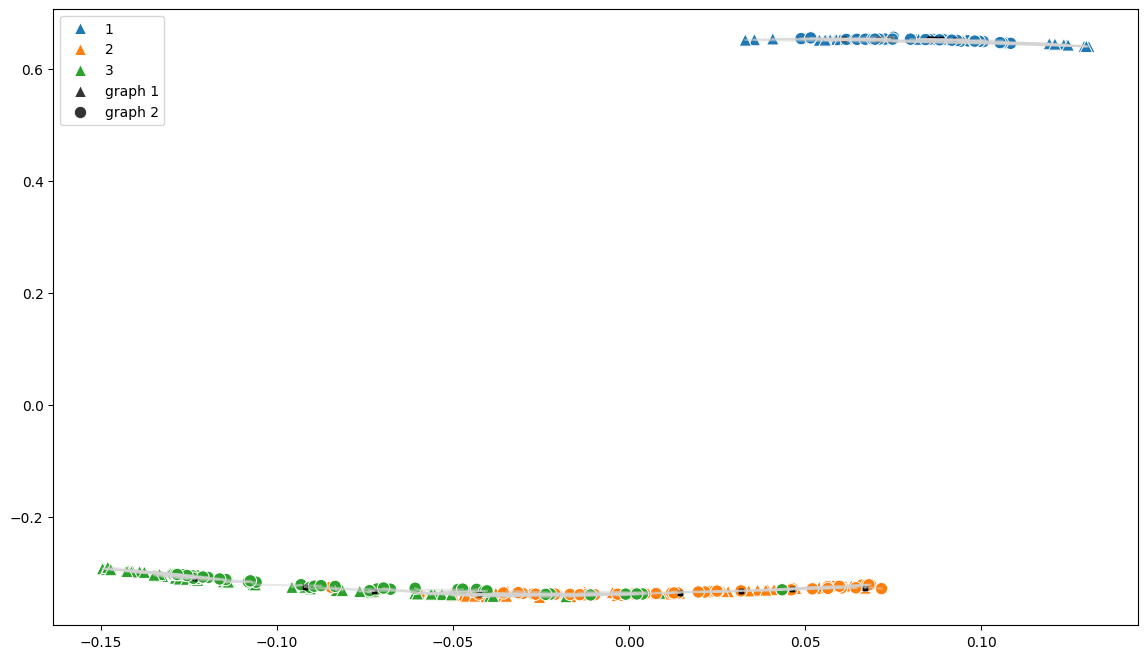

In [4]:
test.plot_emb(labels = dc.labels_doubled, block = test.sim_diffusion_matrix)

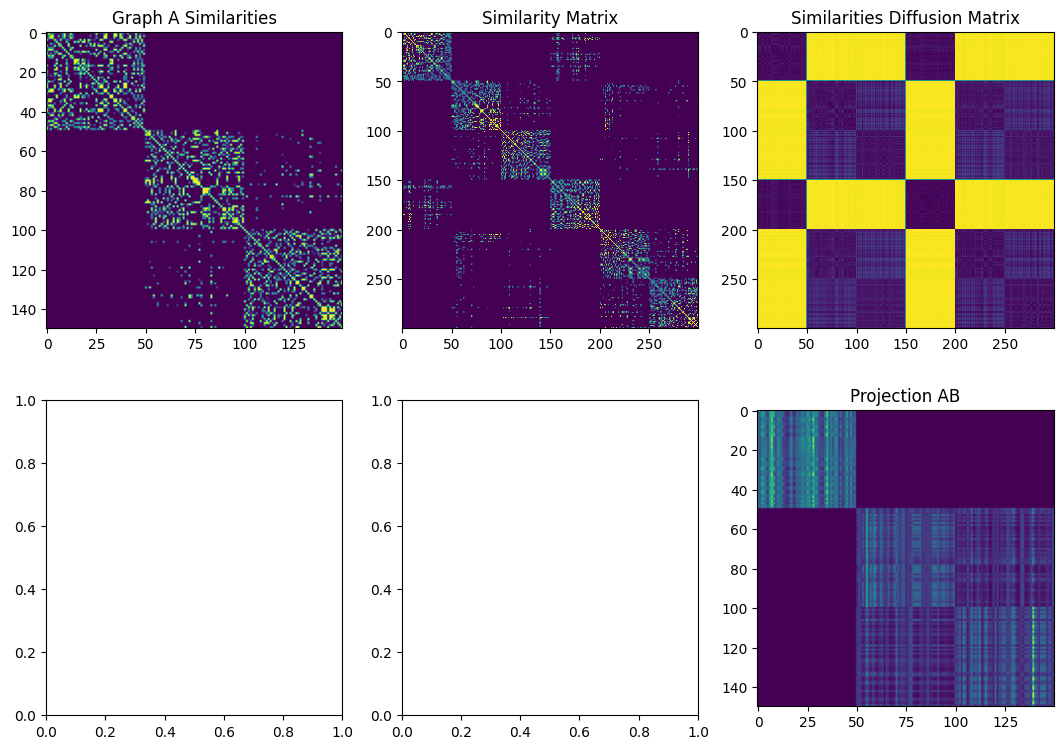

In [5]:
test.plot_graphs()

# Finding the Possible Anchor Tests

## ------------ ----------- Ideas, Questions, and the Mindless ------------ ----------- 

#### Ideas: 
1. We currently force that each point can only have one anchor (because we assume its a one to one correspondonce). However, what if we removed that limitation? Would it be better? My supporting thought for this, is if the algorithm is fairly confident that two points are anchors, they are very similar, and so the algorithm would benefit from thinking them as anchors anyways; even though we know one of the points are wrong
    - > Test setting it to the value instead as of an anchor
2. Sometimes, our hold_out_anchor scores a remarkably high distance from each other. We can maybe set a thing that if no anchors are within the threshold, we can make that hold_out_anchor actually an anchor -- my guess is that it will have the greatest effect on the alignment.

### Questions:
1. 


# 1 to 1 Correspondonce Assumption

This function doesn't allow for a point to have more than one anchor, and always finds anchors

In [6]:
from scipy.optimize import linear_sum_assignment
def _find_possible_anchors(self, anchor_limit = None, threshold = "auto", hold_out_anchors = []): 
    """A helper function that finds and returns a list of possible anchors after alignment.
        
    Parameters:
        :anchor_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float. If auto, the algorithm will determine it.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        
    returns possible anchors plus known anchors in a single list"""

    #Set our array. This lets us modify it if we need to
    array = self.sim_diffusion_matrix[:self.len_A, self.len_A:]

    #Set anchor limit to 1/3 of the unknown data points
    if anchor_limit == None:
        anchor_limit = int((np.min(array.shape) - len(self.known_anchors)) / 3)
    
    #Calculate the predicted anchor value
    if threshold == "auto":

        #Change Type so that we can convert to set 
        known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
        hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

        # Convert the list of tuples to a set for fast look ups
        set1 = set(known_anchors_as_tuples)

        #Remove indicies that are already known anchors
        hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

        #Check to make sure we have Hold out anchors
        if len(hold_out_anchors) < 1:
            print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.")
            return []
        elif len(hold_out_anchors) < 2:
            #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
            threshold = self.sim_diffusion_matrix[hold_out_anchors[0][0], hold_out_anchors[0][1] + self.len_A]

        else:
            #Adjust the Hold_out_anchors to map in the merged graphs
            hold_out_anchors = np.array(hold_out_anchors)

            #Determine the average distance of the hold out anchors
            threshold = np.median(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #NOTE: we might have to adjust this value. 
            _65_percent_interval = np.std(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #If values are outside this range, maybe we through them out?

    """ This section actually finds and then curates potential anchors """
    
    #Alert of chosen Threshold
    print(f"Threshold: {threshold}\n\n")


    #Set the current known anchors to be np.NaN so they aren't calculated, but keep their index
    array[self.known_anchors[:, 0], :] = np.inf
    array[:, self.known_anchors[:, 1]] = np.inf

    hold_out_anchors =np.array(hold_out_anchors)
    array[hold_out_anchors[:, 0], :] = np.inf
    array[:, hold_out_anchors[:, 1]] = np.inf
    
    # Flatten the array and get the sorted indices
    flat_array = array.flatten()
    sorted_indices = np.argsort(flat_array)
    
    # Convert the sorted indices to coordinates
    coordinates = [np.unravel_index(index, array.shape) for index in sorted_indices]
    
    # Create a cost matrix using the top (num_pairs * num_pairs) smallest elements
    selected_coords = coordinates[:anchor_limit * anchor_limit]
    num_elements = len(selected_coords)
    
    # Construct the reduced cost matrix
    cost_matrix = np.full((num_elements, num_elements), np.nanmax(array)*100)
    
    for i, (row_i, col_i) in enumerate(selected_coords):
        for j, (row_j, col_j) in enumerate(selected_coords):
            if row_i != row_j and col_i != col_j:
                cost_matrix[i, j] = array[row_j, col_j]
    
    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create a list to store results
    min_pairs = []

    #Keep track of used rows, and used_cols
    used_rows = set()
    used_cols = set()
    
    #Repeat through the values
    for i in range(len(row_ind)):
        row, col = selected_coords[row_ind[i]]

        #Check to make sure we haven't used the row or column yet (this is becaue is anchor is assumed to have a 1 to 1 correspondence)
        if row not in used_rows and col not in used_cols:

            #Check to see if it is below the threshold
            if array[row, col] < threshold:

                #Add the data
                min_pairs.append((row, col))
                used_rows.add(row)
                used_cols.add(col)

                #Break once we hit our limit
                if len(min_pairs) >= anchor_limit:
                    break
    
    return min_pairs, array


In [7]:
dummy_array = [(10,10), (39,39), (30, 30), (31, 31), (60, 60), (90, 90), (100, 100), (112, 112), (142, 142), (144, 144), (129, 129)]
dummy_array2 = [(133,133), (42, 42)]

In [8]:
test = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)

pairs, array = _find_possible_anchors(test, anchor_limit = None, hold_out_anchors = dummy_array)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

Threshold: 0.026705139239348585


Pair 1: (2, 13) with value 0.0032490920114112923
Pair 2: (47, 41) with value 0.004496281952938521
Pair 3: (29, 38) with value 0.004825697403697636
Pair 4: (24, 20) with value 0.00608694273110936
Pair 5: (42, 34) with value 0.007749315983783966
Pair 6: (9, 42) with value 0.00984504177829935
Pair 7: (11, 37) with value 0.010043883220673054
Pair 8: (49, 43) with value 0.010564764635407231
Pair 9: (37, 45) with value 0.012179347984597346
Pair 10: (93, 93) with value 0.01252232598859538
Pair 11: (34, 3) with value 0.012865014139200643
Pair 12: (98, 53) with value 0.012946179405197452
Pair 13: (40, 49) with value 0.013833635454429831
Pair 14: (81, 89) with value 0.01406892333670194
Pair 15: (1, 47) with value 0.014499646641162366
Pair 16: (25, 29) with value 0.014887687183942929
Pair 17: (3, 9) with value 0.016642245861052767
Pair 18: (20, 36) with value 0.016722125989111075
Pair 19: (80, 94) with value 0.016953756649405006
Pair 20: (38, 2) with value 0.0170

## Testing the validification accuracy of this on repeat

In [9]:
def optimize_by_pred_anchors(self, epochs = 3, **find_possible_anchors_kwargs):
    """Finds potential anchors after alignment, and then recalculates the entire alignment with the new anchor points for each epoch. 
    
    Parameters:
    :anchor_limit: should be an integer. If fixed, it will determine the max anchors the algorithm will find.
    :epochs: the number of iterations the cycle will go through. 
    """
    
    #Rebuild Class for each epoch
    for epoch in range(0, epochs):

        #Find predicted anchors
        predicted_anchors, array = _find_possible_anchors(self, **find_possible_anchors_kwargs)

        if len(predicted_anchors) < 1:
            print("No predicted anchors foud. Exiting process")

            #Add in the known anchors and reset the known_anchors
            if "hold_out_anchors" in find_possible_anchors_kwargs.keys():
                self.known_anchors = np.concatenate((self.known_anchors, find_possible_anchors_kwargs["hold_out_anchors"]), axis = 0)
        else:

            #On the final epoch, we can evaluate with the hold_out_anchors and then assign them as anchors. 
            if epoch == epochs - 1 and "hold_out_anchors" in find_possible_anchors_kwargs.keys():
                predicted_anchors = np.concatenate((find_possible_anchors_kwargs["hold_out_anchors"], predicted_anchors), axis = 0)

            #Add in the known anchors and reset the known_anchors
            self.known_anchors = np.concatenate((self.known_anchors, predicted_anchors), axis = 0)

        #Reconnect the graphs based on the new anchors
        self.graphAB = self.merge_graphs()
        
        #Get Similarity matrix and distance matricies
        self.similarity_matrix = self.get_pure_matricies(self.graphAB)

        #Get Diffusion Matrix
        self.sim_diffusion_matrix, self.projectionAB, self.projectionBA = self.get_diffusion(self.similarity_matrix, self.t, link = self.link)

        if len(predicted_anchors) < 1:
            #Process didn't finish
            return False
        
    #Process Finished
    return True

# Finding close connections alignment 

Maybe there is opportunity here for it to learn things itself? 
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

This algorithm does the following things:
1. It seeks to find the points that have the least distance to each other (and hopefully they are the same point)
2. It then saves those connection values, and uses them in the future to when rebuilding the graph connections ... (It doesn't save them to known anchors though, but a different variable list)
3. It thens tests the new alignment (If we use labels, we can also compare CE):
    1. If the scores are better, it keeps the alignment. 
    2. if the Scores are worse, it prunes those values and throws out the alignment? (Do we want to add a weight between those values?)
4. Then it repeats the process for a certain amount of epochs or until the algorithm no longer improves
    


In [10]:
def _find_new_connections(self, pruned_connections = [], connection_limit = None, threshold = "auto", hold_out_anchors = []): 
    """A helper function that finds and returns a list of possible anchors and their associated wieghts after alignment.
        
    Parameters:
        :connection_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float. If auto, the algorithm will determine it.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        :pruned_connections: should be a list formated like Known Anchors. The node connections in this list will not be considered
            for possible connections. 
        
    returns possible anchors plus known anchors in a single list"""

    #Keep Track of known-connections TODO: WE ALSO NEED TO KEEP TRACK OF THE HOLD_OUT_ANCHORS SOME HOW TOO
    known_connections = self.similarity_matrix > 0 #Creates a mask of everywhere we have a connection

    #Set our Known-connections to inf values so they are not found and changed
    array = self.sim_diffusion_matrix
    array[known_connections] = np.inf

    #Modify our array just to be the off-diagonal 
    array = array[:self.len_A, self.len_A:]

    #Add in our pruned connections
    array[pruned_connections] = np.inf

    #Set anchor limit to 1/3 of the unknown data points
    if connection_limit == None:
        connection_limit = int((np.min(array.shape) - len(self.known_anchors)) / 3)
    
    #Calculate the predicted anchor value
    if threshold == "auto":

        #Change Type so that we can convert to set 
        known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
        hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

        # Convert the list of tuples to a set for fast look ups
        set1 = set(known_anchors_as_tuples)

        #Remove indicies that are already known anchors
        hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

        #Check to make sure we have Hold out anchors
        if len(hold_out_anchors) < 1:
            print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.\n Also Check to see if Threshold is set. \n ---------------------------------------------------------------------------------------------")
            return []
        elif len(hold_out_anchors) < 2:
            #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
            threshold = self.sim_diffusion_matrix[hold_out_anchors[0][0], hold_out_anchors[0][1] + self.len_A]

        else:
            #Adjust the Hold_out_anchors to map in the merged graphs
            hold_out_anchors = np.array(hold_out_anchors)

            #Determine the average distance of the hold out anchors
            threshold = np.median(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #NOTE: we might have to adjust this value. 
            _65_percent_interval = np.std(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #If values are outside this range, maybe we through them out?

        #Alert of chosen Threshold
        print(f"Threshold: {threshold}\n\n")

    else:
        print("Threshold Provided. We are not using the Hold-out anchors.\n")

    """ This section actually finds and then curates potential anchors """

    
    # Flatten the array
    array_flat = array.flatten()

    # Get the indices that would sort the array
    smallest_indices = np.argsort(array_flat)

    # Select the indices of the first 5 smallest values
    smallest_indices = smallest_indices[:connection_limit]

    # Convert the flattened indices to tuple coordinates (row, column)
    coordinates = [np.unravel_index(index, array.shape) for index in smallest_indices]

    #Add in coordinate values as the third index in the tuple
    coordinates = [(int(coordinate[0]), int(coordinate[1]), array[coordinate[0], coordinate[1]]) for coordinate in coordinates]

    #Apply the Threshold
    from itertools import takewhile
    coordinates = np.array(list(takewhile(lambda x: x[2] < threshold, coordinates)))

    return coordinates, array

In [11]:
dummy_array = [(10,10), (39,39), (30, 30), (31, 31), (60, 60), (90, 90), (100, 100), (112, 112), (142, 142), (144, 144), (129, 129)]
dummy_array2 = [(133,133), (42, 42)]

In [12]:
test = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 4, link = "None", verbose = 2)

pairs, array = _find_new_connections(test, connection_limit = None, hold_out_anchors = dummy_array2)
# Print the pairs and their corresponding values
for i, (row, col, val) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {val}")

Threshold: 0.12479666640659409


Pair 1: (26.0, 31.0) with value 0.006538984924532017
Pair 2: (26.0, 28.0) with value 0.008863455255228147
Pair 3: (28.0, 26.0) with value 0.009485497800212721
Pair 4: (23.0, 28.0) with value 0.013002207701908151
Pair 5: (13.0, 41.0) with value 0.013240800907771539
Pair 6: (28.0, 23.0) with value 0.013409076583793662
Pair 7: (38.0, 41.0) with value 0.013666320899039549
Pair 8: (26.0, 39.0) with value 0.013693249004828803
Pair 9: (42.0, 8.0) with value 0.013693695085479126
Pair 10: (42.0, 13.0) with value 0.01376432537058884
Pair 11: (42.0, 41.0) with value 0.013812316868828313
Pair 12: (3.0, 13.0) with value 0.014733721032049747
Pair 13: (35.0, 25.0) with value 0.01604421810119279
Pair 14: (0.0, 23.0) with value 0.016263657015595033
Pair 15: (13.0, 13.0) with value 0.016434822474861995
Pair 16: (38.0, 13.0) with value 0.016812625659192632
Pair 17: (31.0, 26.0) with value 0.016976812976415102
Pair 18: (3.0, 41.0) with value 0.017065784007145438
Pair 19: (

## Testing the algorithm with many epochs

In [13]:
def _update_anchors(self, anchors):
    """If there are no anchors, this algorithm resets all the data associated with that.
    It should be only accessed by the class"""

    #Add anchors
    self.known_anchors = np.concatenate((self.known_anchors, anchors), axis = 0)

    #Reconnect the graphs based on the new anchors
    self.graphAB = self.merge_graphs()
    
    #Get Similarity matrix and distance matricies
    self.similarity_matrix = self.get_pure_matricies(self.graphAB)

In [62]:
from sklearn.manifold import MDS
def optimize_by_creating_connections(self, epochs = 3, **find_possible_connections_kwargs):
    """Finds potential anchors after alignment, and then recalculates the entire alignment with the new anchor points for each epoch. 
    
    Parameters:
    :anchor_limit: should be an integer. If fixed, it will determine the max anchors the algorithm will find.
    :epochs: the number of iterations the cycle will go through. 
    """

    #Create a list to return diffusion matrices NOTE: we can delete this later, simply for my testing sanity
    dif_list = []

    #Set pruned_connections to equal hold_out_anchhor connections if they exist, empty otherwise
    if "hold_out_anchors" in find_possible_connections_kwargs.keys():
        #Firt add the anchor connections
        pruned_connections = [(anchor[0], anchor[1]) for anchor in find_possible_connections_kwargs["hold_out_anchors"]]

        #Add in the the connections of each neighbor to each anchor
        for anchor_pair in find_possible_connections_kwargs["hold_out_anchors"]: #TODO: Vectorize this somehow?

            #Add the connections
            pruned_connections += [(neighbor, anchor_pair[1]) for neighbor in set(self.graphA.neighbors(anchor_pair[0], mode="out"))]
            pruned_connections += [(anchor_pair[0], neighbor) for neighbor in set(self.graphB.neighbors(anchor_pair[1], mode="out"))]
        
    else:
        pruned_connections = []

    #Convert to a Numpy array
    pruned_connections = np.array(pruned_connections).astype(int)

    #Get the current score of the alignment
    current_score = np.mean([self.FOSCTTM(self.sim_diffusion_matrix[self.len_A:, :self.len_A]), self.FOSCTTM(self.sim_diffusion_matrix[:self.len_A, self.len_A:])])
    
    #Rebuild Class for each epoch
    for epoch in range(0, epochs):

        #Find predicted anchors
        new_connections, array = _find_new_connections(self, pruned_connections, **find_possible_connections_kwargs)

        if len(new_connections) < 1:
            print("No new_connections. Exiting process")

            #Add in the known anchors and reset the known_anchors and other init variables
            if "hold_out_anchors" in find_possible_connections_kwargs.keys():
                _update_anchors(self, find_possible_connections_kwargs["hold_out_anchors"])

                #Get Diffusion Matrix
                self.sim_diffusion_matrix, self.projectionAB, self.projectionBA = self.get_diffusion(self.similarity_matrix, self.t, link = self.link)

            #Return false to signify we didn't go through all the tests
            return dif_list

        #Continue to show connections
        print(f"New connections found: {len(new_connections)}")

        if self.verbose > 0:
            print("----------------------   Connections Below   ----------------------")
            for i, (row, col, val) in enumerate(new_connections):
                print(f"Pair {i+1}: ({row}, {col}) with value {val}")
                
            print("\n\n\n")

        #On the final epoch, we can evaluate with the hold_out_anchors and then assign them as anchors. 
        if epoch == epochs - 1 and "hold_out_anchors" in find_possible_connections_kwargs.keys():
            _update_anchors(self, find_possible_connections_kwargs["hold_out_anchors"])

        #Add the new_connections
        new_similarity_matrix = self.similarity_matrix
        new_similarity_matrix[new_connections[:, 0].astype(int), (new_connections[:, 1] + self.len_A).astype(int)] = 1 - new_connections[:, 2] #The 1 minus is supposed to help go from distance to similarities

        #Get new Diffusion Matrix
        new_sim_diffusion_matrix, new_projectionAB, new_projectionBA = self.get_diffusion(new_similarity_matrix, self.t, link = self.link)

        #Get the new score
        new_score = np.mean([self.FOSCTTM(new_sim_diffusion_matrix[self.len_A:, :self.len_A]), self.FOSCTTM(new_sim_diffusion_matrix[:self.len_A, self.len_A:])])

        #See if the extra connections helped
        if True: #new_score < current_score: #This second half is the original code
            print(f"The new connections improved the alignment by {current_score - new_score}\n-----------     Keeping the new alignment. Continuing...    -----------\n")
            
            #Add it to diff_lists
            dif_list.append(new_sim_diffusion_matrix)

            #Reset all the class variables
            self.similarity_matrix = new_sim_diffusion_matrix
            self.sim_diffusion_matix = new_sim_diffusion_matrix
            self.projectionAB = new_projectionAB
            self.projectionBA = new_projectionBA

            #Reset the score
            current_score = new_score

        else:
            print(f"The new connections worsened the alignment by {new_score - current_score}\n-----------     Pruning the new connections. Continuing...    -----------\n")

            #Add the added connections to the the pruned_connections
            pruned_connections = np.append(pruned_connections, new_connections[:, :2]).astype(int)
        
    #Process Finished
    return dif_list

In [68]:
test = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 4, link = "None", verbose = 0)

results = optimize_by_creating_connections(test, epochs = 20, connection_limit = 60, threshold = 0.2)

Threshold Provided. We are not using the Hold-out anchors.

New connections found: 60
The new connections improved the alignment by 0.0005555555555555591
-----------     Keeping the new alignment. Continuing...    -----------

Threshold Provided. We are not using the Hold-out anchors.

No new_connections. Exiting process


Not enough passed epochs


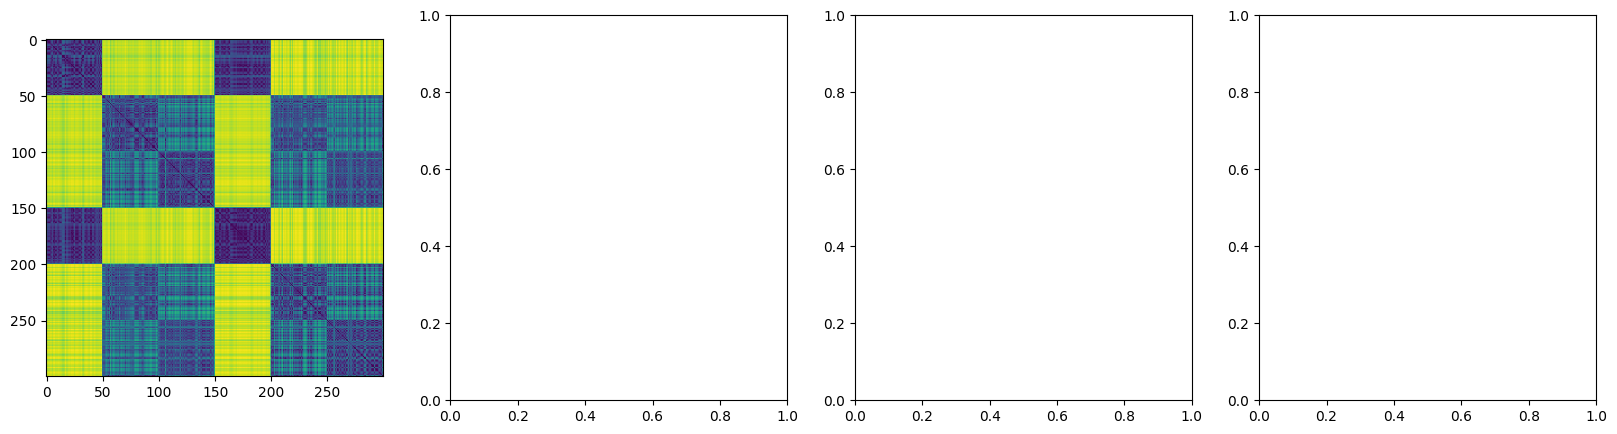

In [69]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
try:
    axs[0].imshow(results[0])
    axs[1].imshow(results[1])
    axs[2].imshow(results[2])
except:
    print("Not enough passed epochs")

In [70]:
np.max(test.sim_diffusion_matrix)

inf

In [71]:
test.plot_emb(labels = dc.labels_doubled, block = test.sim_diffusion_matrix)

ValueError: Input X contains infinity or a value too large for dtype('float64').

## Veiwing the distribution

(                  0
 count  2.250000e+04
 mean            inf
 std             NaN
 min    7.340928e-03
 25%    1.011256e-01
 50%    2.703489e-01
 75%    9.323969e-01
 max             inf,
 <Axes: >)

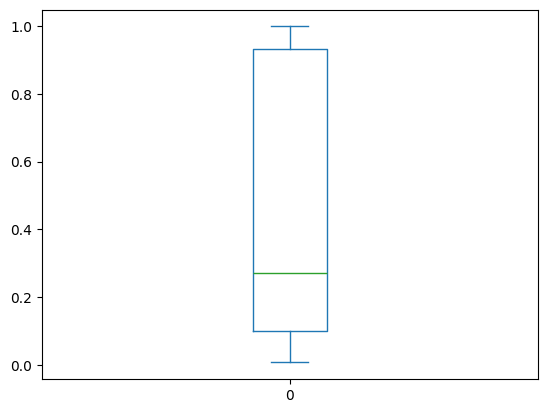

In [ ]:
#Viewing the distribution
all_points  = pd.DataFrame(array.flatten())
all_points.describe(), all_points.plot(kind = "box")

# Veiwing Distribution of Anchors

In [ ]:
unused_anchors = dc.anchors[~np.isin(dc.anchors, test.known_anchors)[:,0]]

In [ ]:
len(unused_anchors), len(test.known_anchors)

(134, 16)

In [ ]:
pd.DataFrame(test.sim_diffusion_matrix[unused_anchors[:, 0], unused_anchors[0, 1] + test.len_A]).describe()

,0
count,134.000000
mean,0.381234
std,0.409395
min,0.034316
25%,0.078658
50%,0.141391
75%,0.980074
max,0.984938


<Axes: >

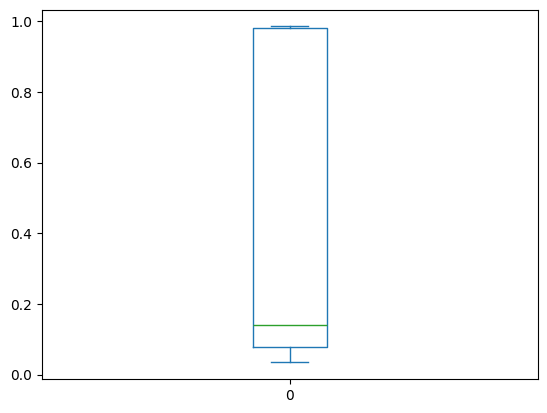

In [ ]:
pd.DataFrame(test.sim_diffusion_matrix[unused_anchors[:, 0], unused_anchors[0, 1] + test.len_A]).plot(kind = "box")

In [ ]:
test.known_anchors, len(test.known_anchors)

(array([[ 28,  28],
        [  6,   6],
        [ 70,  70],
        [ 62,  62],
        [ 57,  57],
        [ 35,  35],
        [ 26,  26],
        [139, 139],
        [ 22,  22],
        [108, 108],
        [  8,   8],
        [  7,   7],
        [ 23,  23],
        [ 55,  55],
        [ 59,  59],
        [129, 129]]),
 16)

In [ ]:
optimize_by_pred_anchors(test, epochs = 5, anchor_limit = 1, hold_out_anchors = dummy_array)

Threshold: 0.03565677437323917


Threshold: 0.04329099798336104


Threshold: 0.04801370496916181


Threshold: 0.05919426697506458


Threshold: 0.05904686097703667




True

In [ ]:
test.known_anchors, len(test.known_anchors)

(array([[ 28,  28],
        [  6,   6],
        [ 70,  70],
        [ 62,  62],
        [ 57,  57],
        [ 35,  35],
        [ 26,  26],
        [139, 139],
        [ 22,  22],
        [108, 108],
        [  8,   8],
        [  7,   7],
        [ 23,  23],
        [ 55,  55],
        [ 59,  59],
        [129, 129],
        [ 49,  49],
        [ 24,  11],
        [ 11,   9],
        [ 29,  38],
        [ 10,  10],
        [ 39,  39],
        [ 30,  30],
        [ 31,  31],
        [ 60,  60],
        [ 90,  90],
        [100, 100],
        [112, 112],
        [142, 142],
        [144, 144],
        [129, 129],
        [  2,  13]]),
 32)

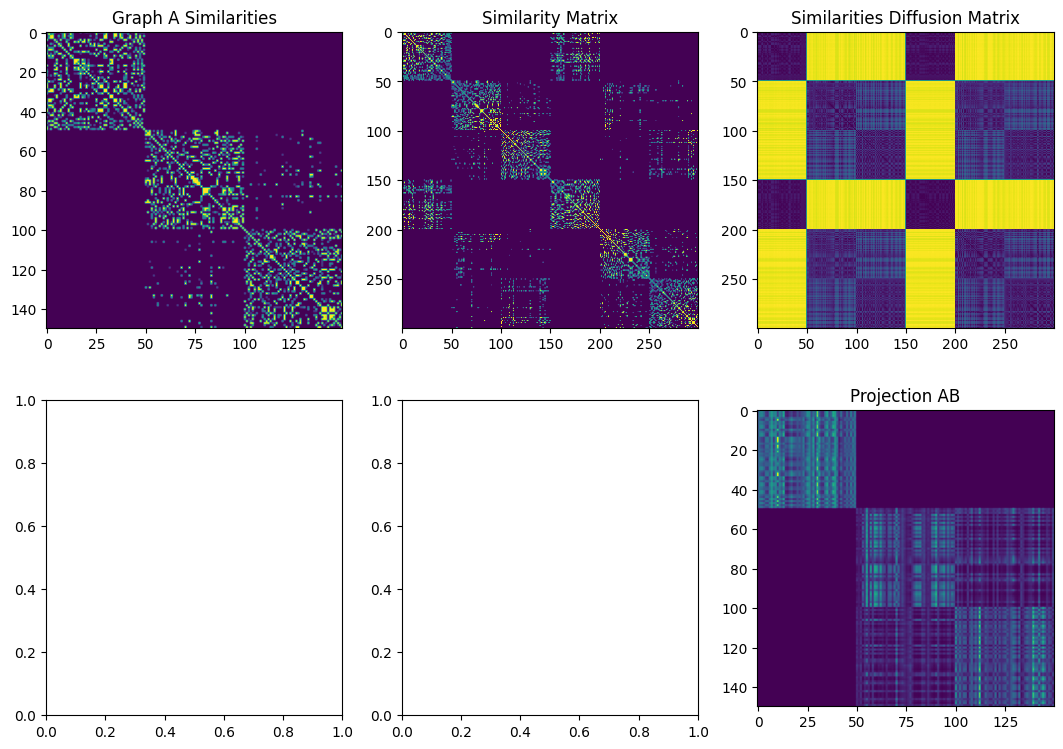

In [ ]:
test.plot_graphs()

Model Stress: 6.140821109294912
Cross Embedding: 0.88
FOSCTTM: 0.07275555555555556


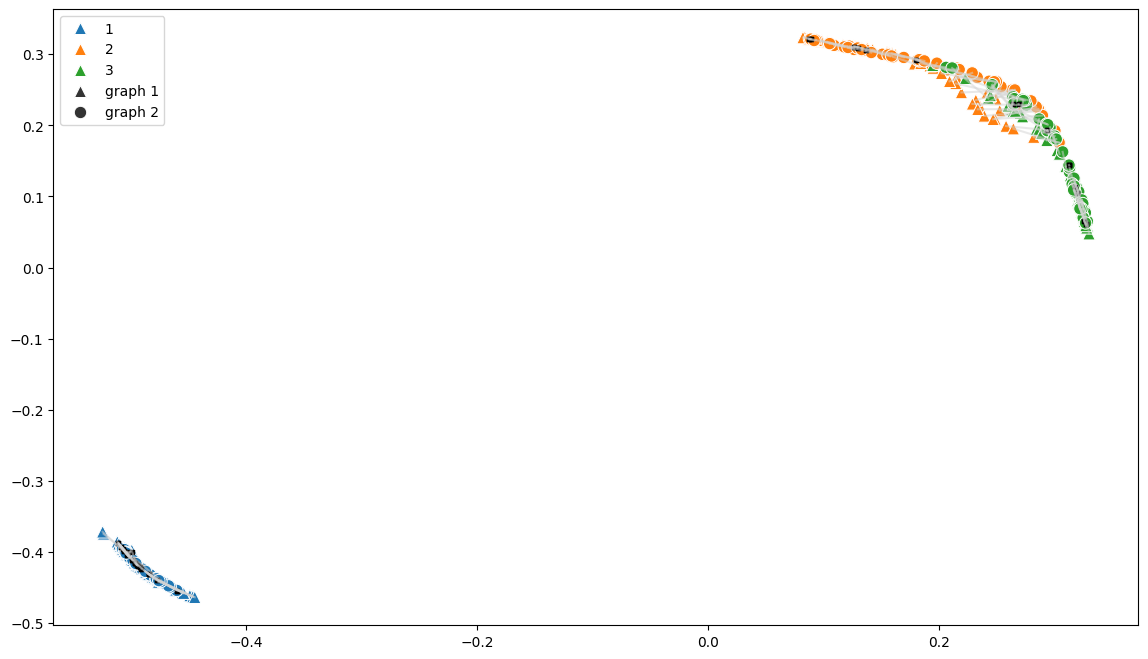

In [ ]:
test.plot_emb(labels = dc.labels_doubled, block = test.sim_diffusion_matrix)

# Visualizing the problem
"""A lot of the points are closest to a certain point --- and that one that is closest to that point is the anchor""" --> Not True 

In [ ]:
test = DIG_V2.DIG(dc.split_A, dc.split_B, dc.anchors[:15], t = -1, knn = 2, link = "None", verbose = 2)

In [ ]:
test.known_anchors

array([[ 28,  28],
       [  6,   6],
       [ 70,  70],
       [ 62,  62],
       [ 57,  57],
       [ 35,  35],
       [ 26,  26],
       [139, 139],
       [ 22,  22],
       [108, 108],
       [  8,   8],
       [  7,   7],
       [ 23,  23],
       [ 55,  55],
       [ 59,  59]])

In [ ]:
array = test.sim_diffusion_matrix[:test.len_A, test.len_A:]

#Get rid of the known anchors
#array[test.known_anchors[:, 0], :] = np.inf
array[:, test.known_anchors[:, 1]] = np.inf

#Loop through each row
for row in range(0, test.len_A):
    #Get the anchor value
    anc_value = array[row, row]

    #Get the min position value
    min_pos = np.argmin(array[row, :])

    #Get the min value
    min_value = np.min(array[row, :])

    print(f"Row {row}: The mininum position is {min_pos} with a value of {min_value}. The anchor value is {anc_value}\n")

Row 0: The mininum position is 36 with a value of 0.06677937244906189. The anchor value is 0.11394426309754033

Row 1: The mininum position is 13 with a value of 0.25536990714805863. The anchor value is 0.3576162992600974

Row 2: The mininum position is 13 with a value of 0.11417309652747559. The anchor value is 0.2694098659288724

Row 3: The mininum position is 13 with a value of 0.12263049098696895. The anchor value is 0.13691318075443387

Row 4: The mininum position is 0 with a value of 0.08194657797262213. The anchor value is 0.12919640380896538

Row 5: The mininum position is 31 with a value of 0.44981642613985384. The anchor value is 0.46846491383919947

Row 6: The mininum position is 30 with a value of 0.050183592772726646. The anchor value is inf

Row 7: The mininum position is 1 with a value of 0.05146817235550426. The anchor value is inf

Row 8: The mininum position is 38 with a value of 0.026028907858531927. The anchor value is inf

Row 9: The mininum position is 13 with a v

# Testing with SPUD

In [ ]:
from scipy.optimize import linear_sum_assignment
def _find_possible_anchors3(self, anchor_limit = None, threshold = "auto", hold_out_anchors = []): 
    """A helper function that finds and returns a list of possible anchors after alignment.
        
    Parameters:
        :anchor_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float. If auto, the algorithm will determine it.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        
    returns possible anchors plus known anchors in a single list"""

    #Set our array. This lets us modify it if we need to
    len_A = self.graphA.vcount()
    array = self.block[:len_A, len_A:]

    #Set anchor limit to 1/3 of the unknown data points
    if anchor_limit == None:
        anchor_limit = int((np.min(array.shape) - len(self.known_anchors)) / 3)
    
    #Calculate the predicted anchor value
    if threshold == "auto":

        #Change Type so that we can convert to set 
        known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
        hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

        # Convert the list of tuples to a set for fast look ups
        set1 = set(known_anchors_as_tuples)

        #Remove indicies that are already known anchors
        hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

        #Check to make sure we have Hold out anchors
        if len(hold_out_anchors) < 1:
            print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.")
            return []
        elif len(hold_out_anchors) < 2:
            #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
            threshold = array[hold_out_anchors[0][0], hold_out_anchors[0][1]]

        else:
            #Adjust the Hold_out_anchors to map in the merged graphs
            hold_out_anchors = np.array(hold_out_anchors)

            #Determine the average distance of the hold out anchors
            threshold = np.median(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #NOTE: we might have to adjust this value. 
            _65_percent_interval = np.std(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #If values are outside this range, maybe we through them out?

    """ This section actually finds and then curates potential anchors """
    
    #Alert of chosen Threshold
    print(f"Threshold: {threshold}\n\n")


    #Set the current known anchors to be np.NaN so they aren't calculated, but keep their index
    array[self.known_anchors[:, 0], :] = np.NaN
    array[:, self.known_anchors[:, 1]] = np.NaN

    hold_out_anchors =np.array(hold_out_anchors)
    array[hold_out_anchors[:, 0], :] = np.NaN
    array[:, hold_out_anchors[:, 1]] = np.NaN
    
    # Flatten the array and get the sorted indices
    flat_array = array.flatten()
    sorted_indices = np.argsort(flat_array)
    
    # Convert the sorted indices to coordinates
    coordinates = [np.unravel_index(index, array.shape) for index in sorted_indices]
    
    # Create a cost matrix using the top (num_pairs * num_pairs) smallest elements
    selected_coords = coordinates[:anchor_limit * anchor_limit]
    num_elements = len(selected_coords)
    
    # Construct the reduced cost matrix
    cost_matrix = np.full((num_elements, num_elements), np.nanmax(array)*10)
    
    for i, (row_i, col_i) in enumerate(selected_coords):
        for j, (row_j, col_j) in enumerate(selected_coords):
            if row_i != row_j and col_i != col_j:
                cost_matrix[i, j] = array[row_j, col_j]
    
    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create a list to store results
    min_pairs = []

    #Keep track of used rows, and used_cols
    used_rows = set()
    used_cols = set()
    
    #Repeat through the values
    for i in range(len(row_ind)):
        row, col = selected_coords[row_ind[i]]

        #Check to make sure we haven't used the row or column yet (this is becaue is anchor is assumed to have a 1 to 1 correspondence)
        if row not in used_rows and col not in used_cols:

            #Check to see if it is below the threshold
            if array[row, col] < threshold:

                #Add the data
                min_pairs.append((row, col))
                used_rows.add(row)
                used_cols.add(col)

                #Break once we hit our limit
                if len(min_pairs) >= anchor_limit:
                    break
    
    return min_pairs, array


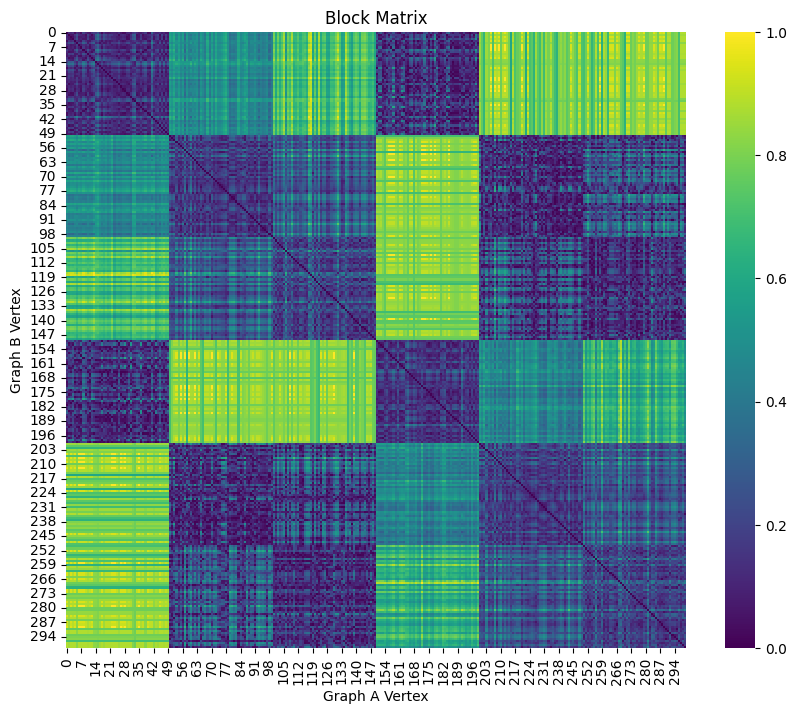

In [ ]:
from SPUD import SPUD
spud =  SPUD(dc.split_A, dc.split_B, dc.anchors[:16], operation = "abs",  knn = 5, kind = "pure", show = True)

In [ ]:
dummy_array = [(10,10), (39,39), (30, 30), (31, 31), (60, 60), (90, 90), (100, 100), (112, 112), (142, 142), (144, 144), (129, 129)]
dummy_array2 = [(133,133), (42, 42)]

In [ ]:
from SPUD import SPUD
spud =  SPUD(dc.split_A, dc.split_B, dc.anchors[:16], operation = "abs", kind = "pure", knn = 5, show = False)

pairs, array = _find_possible_anchors3(spud, anchor_limit = 15, threshold =0.1, hold_out_anchors=dummy_array2)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

Threshold: 0.1


Pair 1: (40, 25) with value 4.026831324399627e-05
Pair 2: (82, 66) with value 8.849540258558386e-05
Pair 3: (91, 101) with value 0.0001599454047140625
Pair 4: (107, 131) with value 0.00019126904471097883
Pair 5: (21, 31) with value 0.00035603605306175345
Pair 6: (51, 88) with value 0.00042951463004647916
Pair 7: (84, 90) with value 0.00048426421539049525
Pair 8: (100, 140) with value 0.0004978900889618387
Pair 9: (33, 11) with value 0.0005748506758199989
Pair 10: (38, 13) with value 0.0006918791627949505
Pair 11: (90, 98) with value 0.0007310777834814708
Pair 12: (137, 125) with value 0.0008167741496411529
Pair 13: (71, 80) with value 0.0008479085758416605
Pair 14: (94, 92) with value 0.0008499665961482217
Pair 15: (37, 45) with value 0.0009312834225209954
